# <center>Parameters selection

In [1]:
import os
workdir = "../.."
os.chdir(workdir)

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')

In [3]:
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from numpy.linalg import LinAlgError

from itertools import product

import warnings

In [4]:
from datetime import datetime, timedelta

In [5]:
import json

In [6]:
import tqdm

In [7]:
from processing.common import read_data, data_preprocessing, data_split, calc_sMAE
from settings import data_path, path_to_model
from models.forecast import SalesForecast

## Замечание о данных для подбора параметров

Для подбора параметров будем использовать данные без последних 31 дней. На этих 31 дней мы будем впоследствии валидировать модели, построенные для каждого из магазинов.

## Готовим данные   

In [8]:
store_id = 8

In [9]:
data = read_data(store_id)

In [10]:
data = data_preprocessing(data, store_id)

In [11]:
prediction_horizon = 31
data, _ = data_split(data, prediction_horizon)

## Посмотрим на данные, изучим визуально сезонность

In [12]:
target_col = "target"

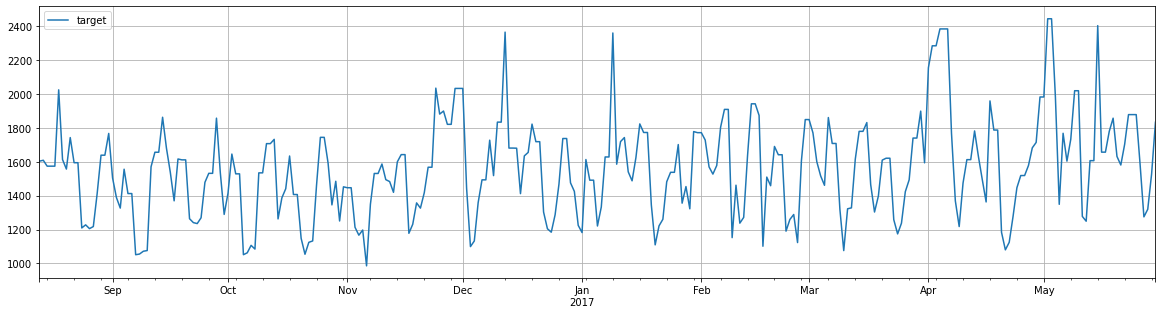

In [13]:
plt.figure(figsize=(20, 5))
data[target_col].plot()
plt.legend()
plt.grid()

## Создадим регрессионные признаки для учёта сезонностей и трендов.

In [14]:
# для недельной сезонности
k_season_series = [1, 2, 3, 4, 5, 6]
hours_in_week = 168 # число часов в неделе
for i in k_season_series:
    data[f'weekly_SIN_{i}'.replace(".", "_")] = np.sin((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)
    data[f'weekly_COS_{i}'.replace(".", "_")] = np.cos((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)

In [15]:
# конец и начало месяца
data['month_end'] = data.index.is_month_end.astype(int)
data['month_start'] = data.index.is_month_start.astype(int)

Добавим в датафрейм день недели и выходной в качестве категориальных переменных

In [16]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6]).astype(int)
data.head()

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend
2016-08-13,1603.4,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0,0,5,1
2016-08-14,1608.6,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0,0,6,1
2016-08-15,1573.8,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781831,0,0,0,0
2016-08-16,1573.8,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,0.623490,0,0,1,0
2016-08-17,1573.8,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,0.433884,0,0,2,0


Добавим признак четной и нечетной недели

In [17]:
data['is_even_week'] = ((data.index.isocalendar().week % 2).astype(int) == 0).astype(int)

In [18]:
data.head(10)

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend,is_even_week
2016-08-13,1603.4,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,9.749279e-01,0,0,5,1,1
2016-08-14,1608.6,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,9.009689e-01,0,0,6,1,1
2016-08-15,1573.8,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,7.818315e-01,0,0,0,0,0
2016-08-16,1573.8,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,6.234898e-01,0,0,1,0,0
2016-08-17,1573.8,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,4.338837e-01,0,0,2,0,0
2016-08-18,2024.3,0.222521,0.974928,0.433884,0.900969,0.623490,0.781831,0.781831,0.623490,0.900969,0.433884,0.974928,2.225209e-01,0,0,3,0,0
2016-08-19,1612.9,0.258819,0.965926,0.500000,0.866025,0.707107,0.707107,0.866025,0.500000,0.965926,0.258819,1.000000,6.123234e-17,0,0,4,0,0
2016-08-20,1556.7,0.294755,0.955573,0.563320,0.826239,0.781831,0.623490,0.930874,0.365341,0.997204,0.074730,0.974928,-2.225209e-01,0,0,5,1,0
2016-08-21,1742.5,0.330279,0.943883,0.623490,0.781831,0.846724,0.532032,0.974928,0.222521,0.993712,-0.111964,0.900969,-4.338837e-01,0,0,6,1,0
2016-08-22,1594.2,0.365341,0.930874,0.680173,0.733052,0.900969,0.433884,0.997204,0.074730,0.955573,-0.294755,0.781831,-6.234898e-01,0,0,0,0,1


## Регрессия целевого признака

In [19]:
# Список призднаков для регрессии
feature_list = []
feature_list = data.drop(target_col, axis=1).columns
feature_list

Index(['weekly_SIN_1', 'weekly_COS_1', 'weekly_SIN_2', 'weekly_COS_2',
       'weekly_SIN_3', 'weekly_COS_3', 'weekly_SIN_4', 'weekly_COS_4',
       'weekly_SIN_5', 'weekly_COS_5', 'weekly_SIN_6', 'weekly_COS_6',
       'month_end', 'month_start', 'weekday', 'is_weekend', 'is_even_week'],
      dtype='object')

### use smf.ols

In [20]:
m1 = smf.ols('target ~ ' + ' + '.join(feature_list), data=data)
# fitted = m1.fit()
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     8.446
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           3.09e-17
Time:                        12:48:36   Log-Likelihood:                -2003.6
No. Observations:                 291   AIC:                             4043.
Df Residuals:                     273   BIC:                             4109.
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1767.0802     31.296     56.463   

Посмотрим на остатки

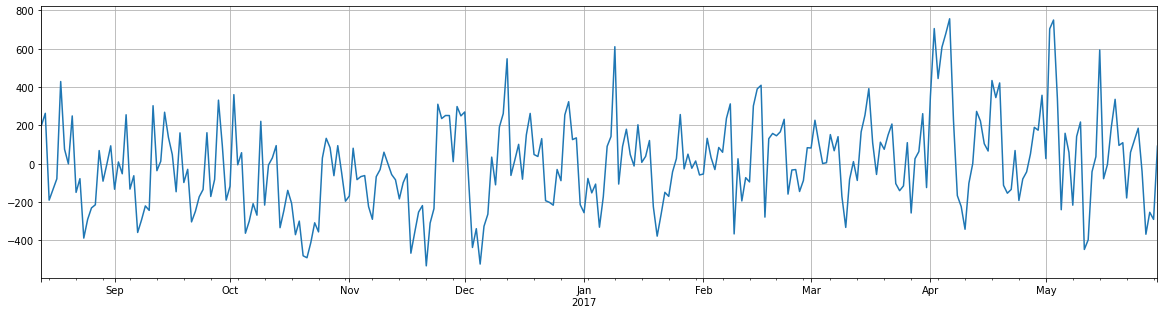

In [21]:
plt.figure(figsize=(20, 5))
fitted.resid.plot();
plt.grid()

В остатках много структуры.

Посмотрим на распределение остатков

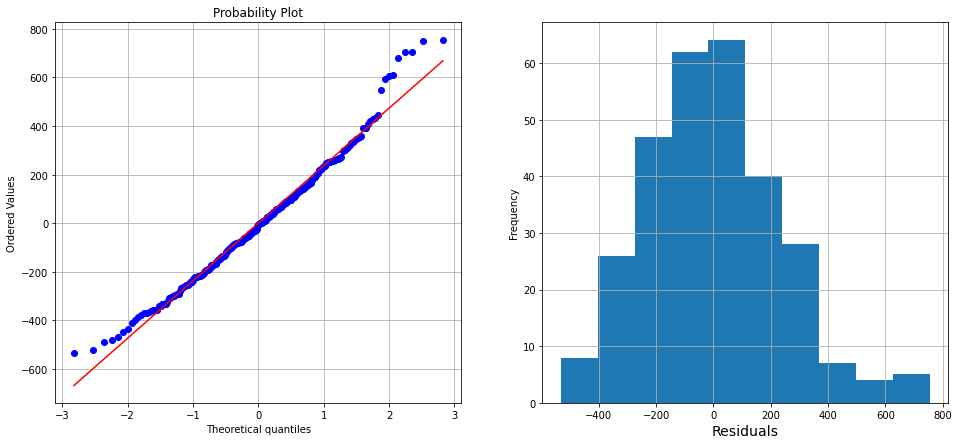

In [22]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.grid()
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.grid()

Распределение близко к гауссову, сделаем некоторые преобразования, чтобы еще более приблизить его к гауссову и к стационарному

## Подбор значения гиперпараметров ARIMA

Посмотрим на **STL-декомпозицию**

Критерий Дики-Фуллера: p=4.731221e-02


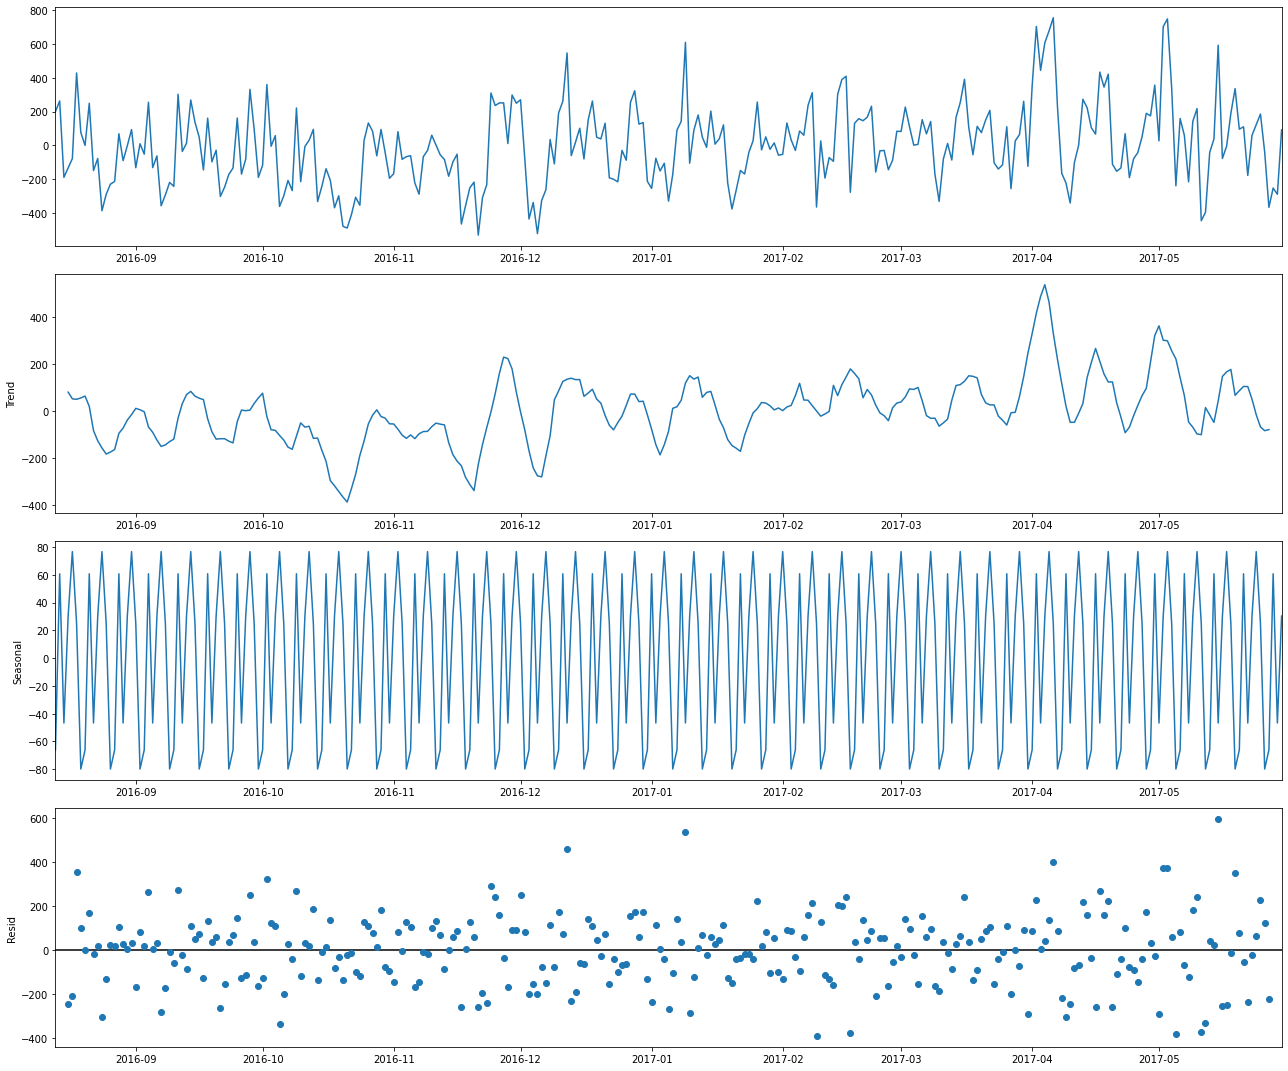

In [23]:
plt.rcParams["figure.figsize"] = (18,15)
sm.tsa.seasonal_decompose(fitted.resid).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(fitted.resid)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, НО, на мой взгляд, не очень уверенно.    
Напрашивается дифференцирование.   

In [24]:
col = {}
lag = 1

Критерий Дики-Фуллера: p=1.276794e-05


<Figure size 1080x720 with 0 Axes>

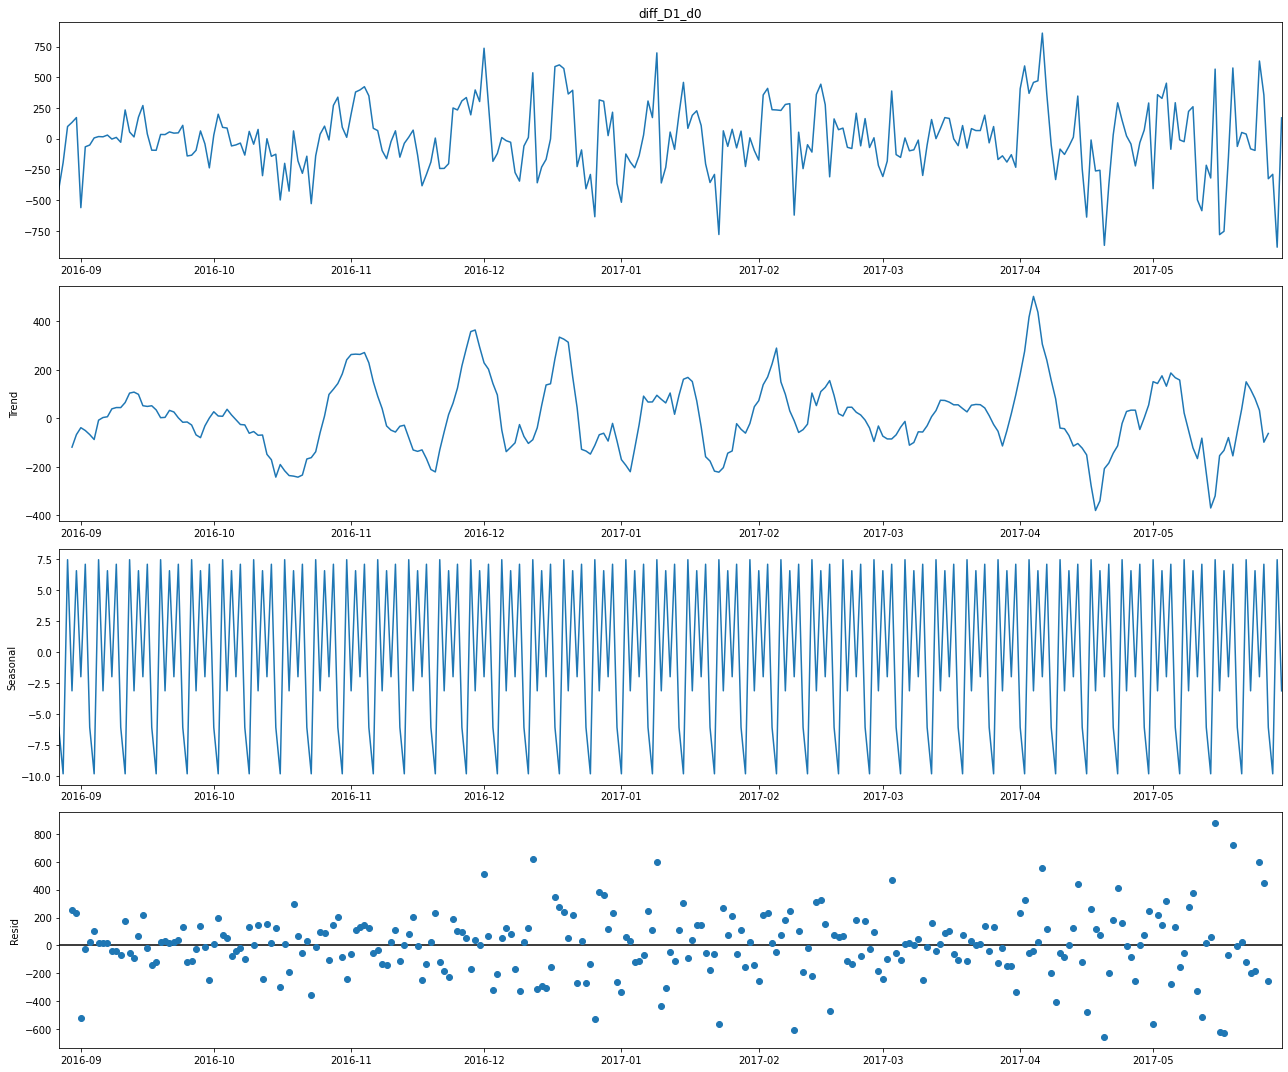

In [25]:
D = 1
S = 14
d = 0
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = fitted.resid - fitted.resid.shift(S)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера: p=5.861114e-12


<Figure size 1080x720 with 0 Axes>

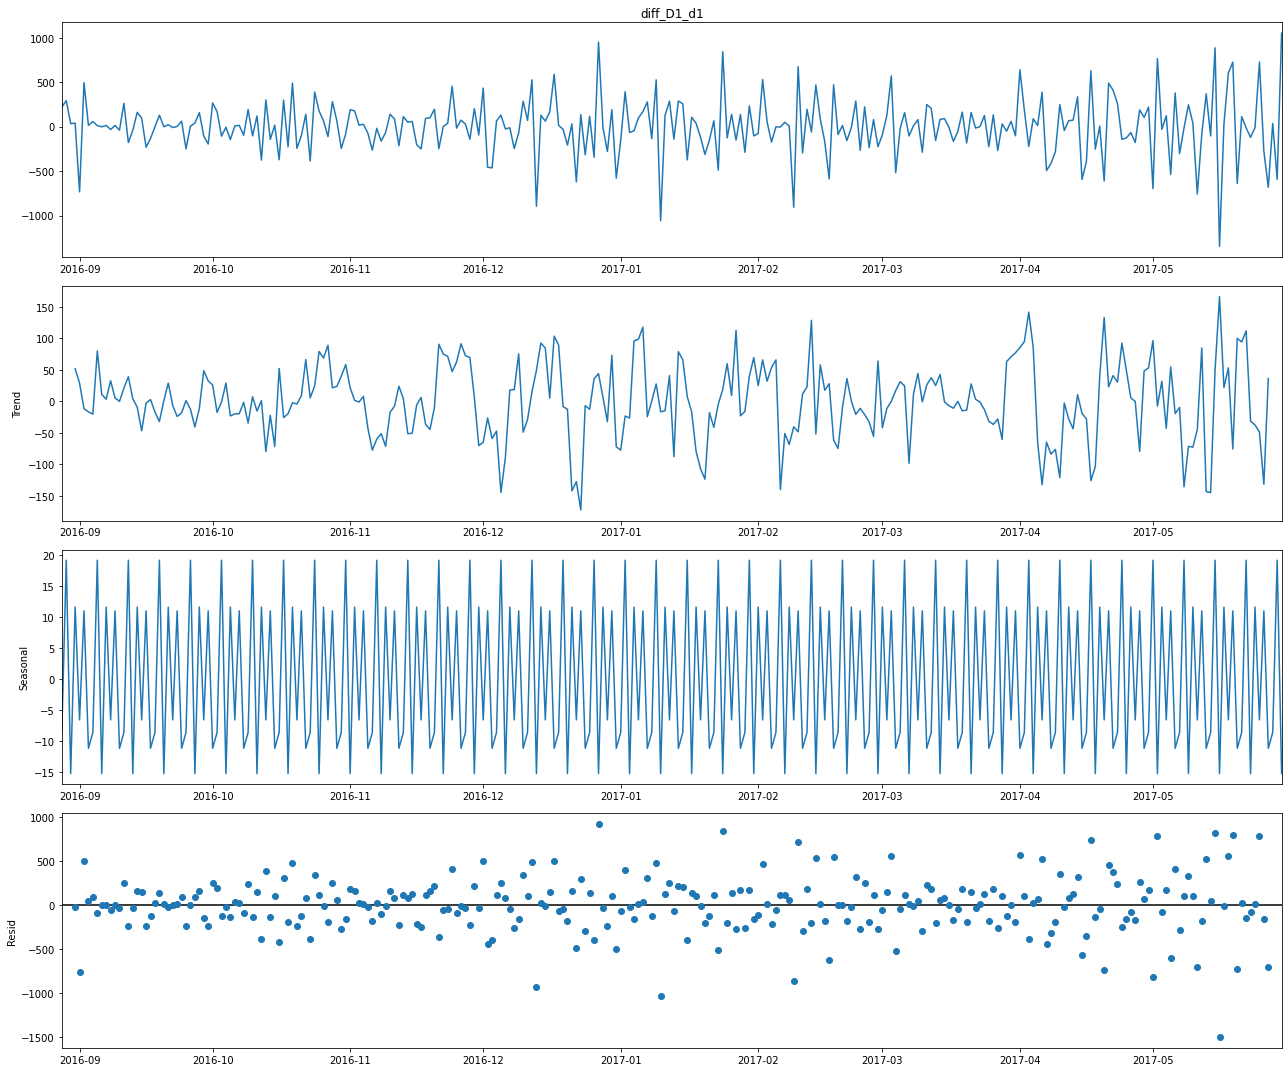

In [26]:
D = 1
S = S
d = 1
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = data[col[(D, d-1)]] - data[col[(D, d-1)]].shift(lag)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера позволяет считать ряд стационарным.   
Мы провели два дифференцирования - сезонное (сезон = 14 дней) и соседних значений.   

### подбираем p,q,P,Q

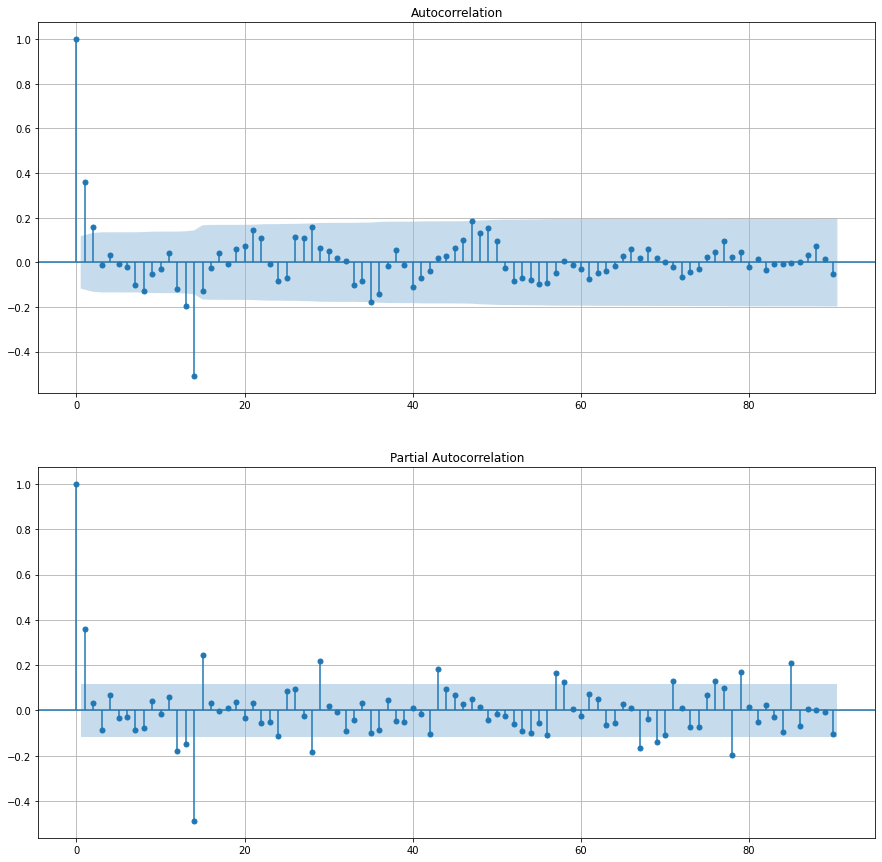

In [27]:
D = 1
d = 0

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

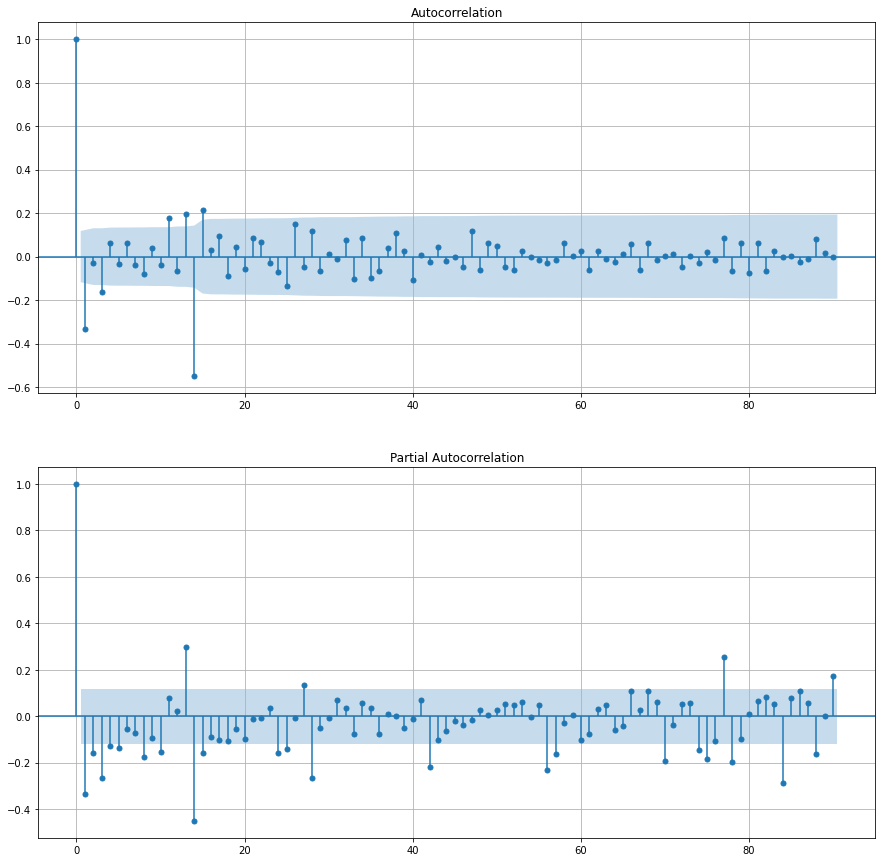

In [30]:
D = 1
d = 0

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

Выводы: хотя критерий Дики-Фуллера позволяет считать ряд стационарным уже после первого сезонного дифференцирования, сезон = 14 дней, но в данных еще видно много структуры. Второе дифференцирование с лагом = 1 день этот вопрос снимает.

$SARIMA(p,d,q)(P,D,Q)_S$

### Подбор AIC модели
- Выберем оптимальную по AIC модель; 
- построим график исходного ряда и нарисуем поверх предсказания выбранной модели. 

Если модель плохо описывает данные, попробуем увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [77]:
D = 1
d = 1
S = S  # 14
lag = lag  # 1

q = 2
p = 1

Q = 1
P = 2

In [78]:
ps = range(p + 1)
qs = range(q + 1)
Ps = range(P + 1)
Qs = range(Q + 1)

In [79]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

#### Функции для сохранения промежуточных результатов
Во время расчетов по подбору оптимальных параметров иногда происходит срубание процесса из-за нехватки ресурсов. При этом все рассчитанные до этого параметры частенько не сохраняются. Чтобы избежать этого, сделаем сохранение результата в каждом цикле. Для этого напишем соответствующую функцию и вставим ее в цикл.

In [80]:
def get_save_params(store_id):
    model_id = f"{store_id}"
    
    # the file names
    model_file_name = f"model_{model_id}.arima"
    hyperparams_file_name = f"hyperparams_{model_id}.json"
    params_df_file_name = f"params_{model_id}.csv"
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [81]:
def save_results(results, best_params, store_id, path_to_model, comment,  k_season_series, model_save=False):
    """
    The save of the current results and best params of the model calculation
    """
    # params for saving
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)
    
    # model
    if model_save:
        best_model.save(os.path.join(path_to_model, model_file_name))
    
    # best params
    best_params_dict = dict()
    best_params_dict['p'] = best_params[0]
    best_params_dict['q'] = best_params[1]
    best_params_dict['d'] = d
    best_params_dict['P'] = best_params[2]
    best_params_dict['Q'] = best_params[3]
    best_params_dict['D'] = D
    best_params_dict['S'] = S
    best_params_dict["k_season_series"] = k_season_series
    best_params_dict['Comment'] = comment

    with open(os.path.join(path_to_model, hyperparams_file_name), "w") as file:
        json.dump(best_params_dict, file)
        
    # common results (all params)
    params_df = pd.DataFrame(list(map(lambda x: x[0], results)), columns=['p', 'q', 'P', 'Q'])
    params_df['aic'] = list(map(lambda x: x[1], results))
    params_df['culc_time_in_minutes'] = list(map(lambda x: x[2], results))
    params_df_sorted = params_df.sort_values(by = 'aic', ascending=True)
    params_df_sorted.to_csv(os.path.join(path_to_model, params_df_file_name))
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [82]:
comment = f"store_id = {store_id}"

### Подбор гиперпараметров модели SARIMA

In [83]:
%%time
results = []
best_aic = float("inf")
best_params = None
warnings.filterwarnings('ignore')

for params in tqdm.tqdm(parameters_list, total=len(parameters_list)):
    start_time = datetime.now()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data[target_col], 
                                        exog=data[feature_list], 
                                        order=(params[0], d, params[1]), 
                                        seasonal_order=(params[2], D, params[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters (ValueError):', params)
        continue
    except LinAlgError:
        print('wrong parameters (LinAlgError):', params)
        continue
    except MemoryError as error:
        print(f"MemoryError message: {error}")
        print('wrong parameters (MemoryError):', params)
        continue
    except Exception as exception:
        print(f"Exception message: {exception}")
        print('wrong parameters (Exception):', params)
        continue
        
    end_time = datetime.now()
    model_culc_time_minutes = round((end_time - start_time).seconds / 60, 2)
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_params = params
    results.append([params, model.aic, model_culc_time_minutes])
    
    # save the current results
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = \
        save_results(results, best_params, store_id, path_to_model, comment,  k_season_series)
    
warnings.filterwarnings('default')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [08:45<00:00, 14.60s/it]

Wall time: 8min 45s


## <center>Посмотрим на результат

In [84]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             target   No. Observations:                  291
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 14)   Log Likelihood               -1858.695
Date:                            Tue, 14 Sep 2021   AIC                           3759.391
Time:                                    20:33:55   BIC                           3835.419
Sample:                                08-13-2016   HQIC                          3789.899
                                     - 05-30-2017                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekly_SIN_1   -45.6267     47.166     -0.967      0.333    -138.071      46.817
weekly_COS_1   -19.6204     45.751     -0.429      0.668    -109.292      70.051
weekly_SIN_2    43.2035     40.607      1.064      0.287     -36.385     122.792
weekly_COS_2     5.1147     39.741      0.129      0.898     -72.776      83.005
weekly_SIN_3    11.8568     33.740      0.351      0.725     -54.273      77.986
weekly_COS_3    63.9877     43.791      1.461      0.144     -21.842     149.817
weekly_SIN_4   -14.6495     39.268     -0.373      0.709     -91.613      62.314
weekly_COS_4   -40.1175     37.895     -1.059      0.290    -114.390      34.155
weekly_SIN_5    23.5456     39.990      0.589      0.556     -54.833     101.924
weekly_COS_5    37.1508     37.245      0.997      0.319     -35.848     110.150
weekly_SIN_6    56.3789     38.676      1.458      0.145     -19.424     132.182
weekly_COS_6   -62.1282     35.177     -1.766      0.077    -131.073       6.817
month_end      -34.6711     60.389     -0.574      0.566    -153.032      83.690
month_start    -53.8497     53.008     -1.016      0.310    -157.743      50.043
weekday         -5.9551   1452.996     -0.004      0.997   -2853.774    2841.864
is_weekend      -0.7648   6693.730     -0.000      1.000   -1.31e+04    1.31e+04
is_even_week    -0.1559   5898.815  -2.64e-05      1.000   -1.16e+04    1.16e+04
ar.L1            0.5208      0.064      8.189      0.000       0.396       0.645
ma.L1           -0.9778      0.038    -25.518      0.000      -1.053      -0.903
ma.S.L14        -0.8503      0.048    -17.859      0.000      -0.944      -0.757
sigma2        3.904e+04   3290.251     11.865      0.000    3.26e+04    4.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                14.00
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)

print("model_id:", model_id)
print("hyperparams_file_name:", hyperparams_file_name)
print("params_df_file_name:", params_df_file_name)
print("model_file_name:", model_file_name)

model_id: 8
hyperparams_file_name: hyperparams_8.json
params_df_file_name: params_8.csv
model_file_name: model_8.arima


### load the best params

In [86]:
# load test
with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
    best_params_dict = json.load(file)
best_params_dict

{'p': 1,
 'q': 1,
 'd': 1,
 'P': 0,
 'Q': 1,
 'D': 1,
 'S': 14,
 'k_season_series': [1, 2, 3, 4, 5, 6],
 'Comment': 'store_id = 8'}

In [87]:
params = pd.read_csv(os.path.join(path_to_model, params_df_file_name), index_col=0)
params.head()

,p,q,P,Q,aic,culc_time_in_minutes
25,1,1,0,1,3759.390532,0.20
29,1,1,2,1,3763.046603,0.47
31,1,2,0,1,3765.063894,0.23
27,1,1,1,1,3765.643833,0.20
35,1,2,2,1,3769.919162,0.33


## sMAE calculation

In [88]:
def calc_id_sMAE(store_id, prediction_horizon=31):
    data = read_data(store_id)
    data = data_preprocessing(data, store_id)
    train, valid = data_split(data, prediction_horizon)
    
    hyperparams_file_name = f"hyperparams_{store_id}.json"    
    with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
        params = json.load(file)
    
    warnings.filterwarnings('ignore')
    sales_forecast = SalesForecast(train, params=params)
    sales_forecast.fit()
    warnings.filterwarnings('default')
    
    predict = sales_forecast.predict(prediction_horizon)
    sMAE = calc_sMAE(predict, valid, train)
    return sMAE

In [89]:
%%time
sMAE = calc_id_sMAE(store_id)

Wall time: 8.77 s


In [90]:
print(f"id: {store_id}, sMAE: {sMAE: 0.3f}")

id: 8, sMAE:  0.179


In [91]:
def calc_id_sMAE_params(store_id, params_id, prediction_horizon=31):
    data = read_data(store_id)
    data = data_preprocessing(data, store_id)
    train, valid = data_split(data, prediction_horizon)
    
    hyperparams_file_name = f"hyperparams_{params_id}.json"    
    with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
        params = json.load(file)
    
    warnings.filterwarnings('ignore')
    sales_forecast = SalesForecast(train, params=params)
    sales_forecast.fit()
    warnings.filterwarnings('default')
    
    predict = sales_forecast.predict(prediction_horizon)
    sMAE = calc_sMAE(predict, valid, train)
    return sMAE

In [92]:
%%time
sMAE_best = float("inf")
params_id_best = None
for params_id in range(8):
    sMAE = calc_id_sMAE_params(store_id, params_id)
    if sMAE <= sMAE_best:
        sMAE_best = sMAE
        params_id_best = params_id
print(f"id: {store_id}, params_id_best: {params_id_best}, sMAE_best: {sMAE_best: 0.3f}")

In [75]:
print(f"id: {store_id}, params_id: {params_id}, sMAE: {sMAE: 0.3f}")

id: 8, params_id: 2, sMAE:  0.254
